# Analysis and visualization of 3D data in Python

Daniela Ushizima, Alexandre de Siqueira, Stéfan van der Walt

_BIDS @ University of California, Berkeley_

_Lawrence Berkeley National Laboratory - LBNL_

* Support material for the tutorial _Analysis and visualization of 3D data in Python_.

This tutorial will introduce how to analyze three dimensional stacked and volumetric
images in Python, mainly using scikit-image. Here we will learn how to:
  * pre-process data using filtering, binarization and segmentation techniques.
  * inspect, count and measure attributes of objects and regions of interest in the data.
  * visualize 3D data.

Please prepare for the tutorial by [installing the pre-requisite
software](preparation.md) beforehand.

For more info:
  * [[ISVC 2019]](https://www.isvc.net/)
  * [[scikit-image]](https://scikit-image.org/)

In [ ]:
#You saw downsampling at 01_filters_segmentation using filtering, now we will explore slicing as a way to downsample 

#foreground vs. background and automated cropping - techniques based on thresholding

#microCT through maxproj


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import supplementary_code as sc

from ipywidgets import interact
from matplotlib import cm
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
from scipy import ndimage as ndi
from scipy import stats

from skimage import (color, data, exposure, feature, filters, io, measure,
                    morphology, restoration, segmentation, transform,
                    util)

%matplotlib inline

# 1. Slicing

Text(0.5, 1.0, 'This image is downsampled by 2')

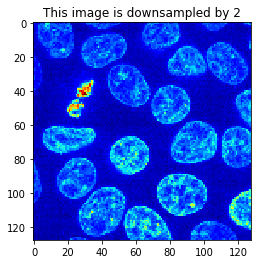

In [8]:
downsample = 2
plt.imshow(data[30,::downsample,::downsample],cmap="jet") #show every $downsample pixels
plt.title('This image is downsampled by ' + str(downsample))

In [ ]:
imageBlock = imageBlock.astype(np.uint8)

# 2. Cropping

Sample center: 128 , 128


Text(0.5, 1.0, 'Central sample crop 30')

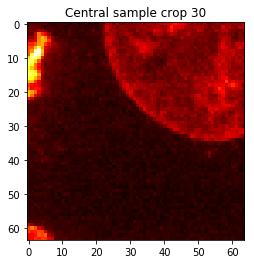

In [11]:
core = data.copy() #warning = making a copy of stack here!!!!
depth, height,width = core.shape
middle = depth//2
print("Sample center:",height//2,",",width//2) 
dh = height//4
dw = width//4
core = core[middle,dh:2*dh,dw:2*dw]
plt.imshow(core,cmap='hot')
plt.title('Central sample crop '+str(middle))

# 3. Maximum projection

In [2]:
#load a large microCT dataset

In [1]:
#Function to return mask and coordinates of bounding box 
import numpy as np
import fnmatch,os
import matplotlib.pyplot as plt

from skimage import img_as_ubyte, filters, morphology, exposure, io
from skimage.filters import threshold_isodata
from skimage.measure import regionprops,label
from skimage.transform import pyramid_expand
from scipy import ndimage as ndi

class CoreObject: 
    
    
    def __init__(self,inputs,outputs): 
        '''Input and output paths
        '''
        self.inputs = inputs
        self.outputs = outputs
        self.mask = [] #mask with inside (255) and outside (0) regions
        self.x = 0
        self.y = 0
        self.xn = 10
        self.yn = 10        

    def detectCore(self):
        ''' Find core of microCT sample using max-projection'''
        #nfiles = len(fnmatch.filter(os.listdir(path),'*.tiff')) #MAKE SURE IT IS
        filename = self.inputs+"*.tiff"
        ic = io.ImageCollection(filename,conserve_memory=True) #never keeps more than 1 slice in mem
        nslices = len(ic)

        ndown = 10 #downsample by a order of magnitude for masking
        IM_MAX = ic[0][::ndown,::ndown]
        for n in np.arange(0,nslices-1,ndown):
            IM_MAX = np.maximum(IM_MAX, ic[n+1][::ndown,::ndown])

        thresh = threshold_isodata(IM_MAX)
        mask = IM_MAX>thresh

        mask = ndi.binary_fill_holes(mask)
        mask = morphology.opening(mask, morphology.disk(2))
        
        #Upsample - TODO: mask different size than orig
        mask = pyramid_expand(mask, upscale=ndown, sigma=None, order=1,multichannel=None)
        thresh = threshold_isodata(mask)

        mask = mask>thresh

        labeled = label(mask)
        regions = regionprops(labeled)
        print("Just one ROI? ",len(regions)==True)
        for props in regions:
            print(props.bbox)
        mask = mask[props.bbox[0]:props.bbox[2],props.bbox[1]:props.bbox[3]]
        #Update class attrib
        self.ic = ic
        self.nslices = len(ic)
        self.mask = mask #reduced cross-sectional area
        self.maxproj = IM_MAX
        self.x = props.bbox[0]
        self.xn = props.bbox[2]
        self.y = props.bbox[1]
        self.yn = props.bbox[3]    
        #Saving mask!!!
        outfile = self.outputs + 'bMaxprojection.tiff'
        plt.imsave(outfile, mask, cmap='gray')

        
    def maskOrigSlice(self,ic_n,save=False):
        ''' Mask a slice with number ic_n and save snapshot
        '''
        c = self
        cropped = []
        if (ic_n <len(self.ic)):
            aSlice = self.ic[ic_n]
            cropped = aSlice[c.x:c.xn, c.y:c.yn]*self.mask
            
            if save:
                #Creating file names that carry experiment prefix
                fname = self.ic.files[ic_n].split("/")
                fname = fname[-1]
                print(fname)
                fname = self.outputs + "mask" + fname + '.tiff'

                
                fig, axes = plt.subplots(1, 1, figsize=(15, 10))
                axes.imshow(cropped * c.mask,cmap='inferno')
                axes.set_title('Masking slice '+str(ic_n))
                axes.set_axis_off()
                plt.tight_layout()
                fig.savefig(fname)
        else:
             print('Stack <',len(self.ic))   
        return cropped    
    
    def montage(self):
        '''Create montage 3x3 that fits a Letter-page'''
        fig, axes = plt.subplots(3, 3, figsize=(20, 20))
        #Selecting a few views among the slices
        delta  = np.round(self.nslices/9)
        islices = np.arange(1,self.nslices,delta)
        islices = islices.astype(int)
        selem = morphology.square(3)
        for i, n in enumerate(islices):
            im_filt = self.maskOrigSlice(n)
            im_filt = ndi.median_filter(im_filt, footprint=selem) #raw image
            xy = np.unravel_index(i, (3,3))
            axes[xy].imshow(im_filt,cmap='gray')
            axes[xy].set_title('Slice %i'% n)
            axes[xy].set_axis_off()
            fig.subplots_adjust( wspace = -0.1,  hspace = 0.1 )    
        fig.savefig(resultsFolder+'SlicesAcross.png')
        print('Saved@ '+resultsFolder+'SlicesAcross.png')

# 3. Probe for global visualization

In [3]:
#1) Read lean: conserve mem
inputFolder = "mikeway"
filename = inputFolder+"*.tiff"
        ic = io.ImageCollection(filename,conserve_memory=True) #never
keeps more than 1 slice in mem
        nslices = len(ic)

#2) Define structure of interest: local/global
if(isglobal):
downsample = 10
data = data[::downsample,::downsample,::downsample]
else:
#define spatial coords. of zone of interest

#3) Ball park
import itk
from itkwidgets import view
#Reformat the numpy array into an itk friendly matrix
image = itk.GetImageFromArray(data.astype(np.int16))
view(image, slicing_planes=True)

/Users/dani/anaconda3/envs/imagej/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
